# Final Alignment Evaluation & Report

**Protocol**: Single unified evaluation for Attention-Pooling and Perceiver-based alignment models.
**Models Evaluation**: Attention+Matryoshka vs Perceiver+Matryoshka.
**Metrics**: R@1/5/10, MRR, MedR over multiple dimensions [4096, ..., 128].
**Outputs**: structured CSVs, LaTeX tables, publication-quality plots.

## 1. Setup & Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, CLIPImageProcessor, CLIPVisionModel, AutoModel

# Add src to path
NOTEBOOK_DIR = Path('.').resolve()
ROOT_DIR = NOTEBOOK_DIR.parent
sys.path.insert(0, str(SRC_PATH := ROOT_DIR / 'src'))
sys.path.insert(0, str(ROOT_DIR))

from data.dataset_builder import PixmoParquetImageTextDataset
from data.transforms import get_image_transforms
from config import load_config
from models.alignment import MultimodalAlignmentModel

# device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

# Output configs
OUTPUT_DIR = ROOT_DIR / 'outputs/alignment_eval_final'
os.makedirs(OUTPUT_DIR, exist_ok=True)

class EvalConfig:
    # Data
    pixmo_val = '/home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet'
    pixmo_test = '/home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_test.parquet'
    
    # Checkpoints
    attn_ckpt = str(ROOT_DIR / 'checkpoints/pixmo_alignment/checkpoint_best.pt')
    attn_config = str(ROOT_DIR / 'configs/pixmo_alignment_1.yaml')
    perc_ckpt = str(ROOT_DIR / 'checkpoints/perceiver_v2/checkpoint-best/pytorch_model/mp_rank_00_model_states.pt')
    
    # Settings
    mrl_dims = [4096, 2048, 1024, 512, 256, 128]
    batch_size = 64
    num_workers = 4
    image_size = 336
    split = 'val' # 'val' or 'test'
    
config = EvalConfig()

# Plotting Style
plt.style.use("tableau-colorblind10")
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({'font.size': 11, 'figure.dpi': 150})

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Running on cuda


## 2. Model Definitions

In [2]:
# --- Perceiver V3 Architecture (Self-Contained) ---
class FeedForward(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden = int(dim * mlp_ratio)
        self.net = nn.Sequential(nn.Linear(dim, hidden), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden, dim), nn.Dropout(dropout))
    def forward(self, x): return self.net(x)

class PerceiverAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.q_proj, self.k_proj, self.v_proj = nn.Linear(dim, dim), nn.Linear(dim, dim), nn.Linear(dim, dim)
        self.out, self.ln_q, self.ln_kv = nn.Linear(dim, dim), nn.LayerNorm(dim), nn.LayerNorm(dim)
    def forward(self, q, kv, mask=None):
        B, N, C = q.shape
        q, kv = self.ln_q(q), self.ln_kv(kv)
        Q = self.q_proj(q).reshape(B, N, self.num_heads, self.head_dim).permute(0,2,1,3)
        K = self.k_proj(kv).reshape(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        V = self.v_proj(kv).reshape(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        attn = (Q @ K.transpose(-2,-1)) * self.scale
        if mask is not None: attn = attn.masked_fill(~mask, float('-inf'))
        return self.out((F.softmax(attn, -1) @ V).transpose(1,2).reshape(B, N, C))

class PerceiverLayer(nn.Module):
    def __init__(self, dim, **kwargs):
        super().__init__()
        self.cross = PerceiverAttention(dim, **kwargs)
        self.self = PerceiverAttention(dim, **kwargs)
        self.ffn = FeedForward(dim, **kwargs)
    def forward(self, x, src, mask=None):
        x = x + self.cross(x, src, mask)
        x = x + self.self(x, x)
        return x + self.ffn(x)

class PerceiverResampler(nn.Module):
    def __init__(self, dim=512, num_latents=64, layers=4, **kwargs):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, dim) * 0.02)
        self.layers = nn.ModuleList([PerceiverLayer(dim, **kwargs) for _ in range(layers)])
        self.ln = nn.LayerNorm(dim)
    def forward(self, x, mask=None):
        latents = self.latents.unsqueeze(0).expand(x.size(0), -1, -1)
        for l in self.layers: latents = l(latents, x, mask)
        return self.ln(latents)

class PerceiverV3Model(nn.Module):
    def __init__(self, d_vision=1024, d_text=384, d_model=512, d_out=512):
        super().__init__()
        self.vision_adapter = nn.Sequential(nn.LayerNorm(d_vision), nn.Linear(d_vision, d_model))
        self.text_adapter = nn.Sequential(nn.LayerNorm(d_text), nn.Linear(d_text, d_model))
        self.perceiver = PerceiverResampler(dim=d_model)
        self.proj = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, d_out))
    def encode_vision(self, x): 
        return self.proj(self.perceiver(self.vision_adapter(x)).mean(1))
    def encode_text(self, x):
        return self.proj(self.perceiver(self.text_adapter(x)).mean(1))

# --- Model Loader ---
def load_models(config, device):
    models = {}
    
    # 1. Encoders (Frozen)
    print("Loading Encoders...")
    clip_vis = CLIPVisionModel.from_pretrained('openai/clip-vit-large-patch14-336').to(device).eval()
    clip_proc = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14-336')
    txt_enc = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device).eval()
    txt_tok = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    
    # 2. Attention Model
    if Path(config.attn_ckpt).exists():
        print("Loading Attention Model...")
        cfg_attn = load_config(config.attn_config)
        attn_model = MultimodalAlignmentModel(cfg_attn).to(device).eval()
        ckpt = torch.load(config.attn_ckpt, map_location=device)
        state = ckpt.get('model_state_dict', ckpt)
        attn_model.load_state_dict(state, strict=False)
        models['attention'] = attn_model
    
    # 3. Perceiver Model
    if Path(config.perc_ckpt).exists():
        print("Loading Perceiver Model...")
        perc_model = PerceiverV3Model().to(device).eval()
        ckpt = torch.load(config.perc_ckpt, map_location=device)
        state = ckpt.get('module', ckpt)
        state = {k.replace('module.', ''):v for k,v in state.items()}
        perc_model.load_state_dict(state, strict=False)
        
        class PercWrapper(nn.Module):
            def __init__(self, p, c, t): super().__init__(); self.p=p; self.c=c; self.t=t
        models['perceiver'] = PercWrapper(perc_model, clip_vis, txt_enc)
        
    return models, clip_proc, txt_tok

## 3. Data & Evaluation Logic

In [3]:
def get_loader(config, split='val'):
    fp = config.pixmo_val if split == 'val' else config.pixmo_test
    ds = PixmoParquetImageTextDataset(
        fp, 
        image_transforms=get_image_transforms(config.image_size, is_training=False),
        max_text_length=512
    )
    def collate(batch):
        batch = [b for b in batch if b]; 
        if not batch: return None
        return {'images': torch.stack([b['image'] for b in batch]), 'texts': [b['text'] for b in batch]}
    return DataLoader(ds, batch_size=config.batch_size, num_workers=config.num_workers, collate_fn=collate, shuffle=False)

@torch.no_grad()
def extract_embeddings(model_dict, loader, device, max_dim=4096, text_tokenizer=None, clip_proc=None):
    # Returns: {model_name: {'vision': tensor, 'text': tensor}}
    outputs = {name: {'v': [], 't': []} for name in model_dict}
    
    for batch in tqdm(loader, desc="Extracting Embeddings"):
        if batch is None: continue
        images = batch['images'].to(device)
        texts = batch['texts']
        
        # Encoders for Perceiver (Attention has them built-in, but handled differently)
        # Note: Attention Model handles raw inputs inside forward.
        # Perceiver needs pre-computation.
        
        # 1. Attention Model
        if 'attention' in model_dict:
            out = model_dict['attention'](images=images, texts=texts, return_embeddings=True)
            outputs['attention']['v'].append(out.vision_emb.cpu())
            outputs['attention']['t'].append(out.text_emb.cpu())
            
        # 2. Perceiver Model
        if 'perceiver' in model_dict:
            # Encode Raw Features
            pm = model_dict['perceiver']
            
            # Vision - already pre-processed by DataLoader
            vis_feats = pm.c(pixel_values=images).last_hidden_state
            
            # Text
            toks = text_tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
            txt_feats = pm.t(**toks).last_hidden_state
            
            # Alignment
            v_emb = pm.p.encode_vision(vis_feats)
            t_emb = pm.p.encode_text(txt_feats)
            
            outputs['perceiver']['v'].append(v_emb.cpu())
            outputs['perceiver']['t'].append(t_emb.cpu())
            
    # Concat
    final_embeds = {}
    for name in outputs:
        final_embeds[name] = {
            'vision': torch.cat(outputs[name]['v']),
            'text': torch.cat(outputs[name]['t'])
        }
    
    return final_embeds

def compute_metrics(v_emb, t_emb, dims=[4096]):
    results = []
    N = v_emb.shape[0]
    targets = torch.arange(N, device=v_emb.device)
    
    for dim in dims:
        # Matryoshka Truncation & Norm
        v = F.normalize(v_emb[:, :dim], p=2, dim=-1)
        t = F.normalize(t_emb[:, :dim], p=2, dim=-1)
        
        # Similarity
        sim = v @ t.T
        
        # I2T
        r_i2t = (sim.argsort(descending=True) == targets.unsqueeze(1)).float()
        rank_i2t = r_i2t.argmax(1) + 1
        
        # T2I
        r_t2i = (sim.T.argsort(descending=True) == targets.unsqueeze(1)).float()
        rank_t2i = r_t2i.argmax(1) + 1
        
        for direction, ranks in [('i2t', rank_i2t), ('t2i', rank_t2i)]:
            res = {
                'dim': dim,
                'direction': direction,
                'R1': (ranks <= 1).float().mean().item() * 100,
                'R5': (ranks <= 5).float().mean().item() * 100,
                'R10': (ranks <= 10).float().mean().item() * 100,
                'MRR': (1.0 / ranks).mean().item(),
                'MedR': ranks.median().item()
            }
            results.append(res)
            
    return results

## 4. Execution Loop

In [4]:
# Load
models, clip_proc, txt_tok = load_models(config, DEVICE)
loader = get_loader(config, split=config.split)

# Extract
print(f"Extracting embeddings for split: {config.split}")
embeddings = extract_embeddings(models, loader, DEVICE, max_dim=4096, text_tokenizer=txt_tok, clip_proc=clip_proc)

# Save Embeddings (Artifact Requirement)
for name, data in embeddings.items():
    p = OUTPUT_DIR / f'embeddings_{config.split}_{name}.pt'
    torch.save(data, p)
    print(f"Saved {name} embeddings to {p}")

# Compute Metrics
all_metrics = []
for name in embeddings:
    print(f"Computing metrics for {name}...")
    v, t = embeddings[name]['vision'].to(DEVICE), embeddings[name]['text'].to(DEVICE)
    res = compute_metrics(v, t, dims=config.mrl_dims)
    for r in res:
        r.update({'model': name, 'split': config.split})
        all_metrics.append(r)

# Master DataFrame
df_master = pd.DataFrame(all_metrics)
df_master.to_csv(OUTPUT_DIR / 'alignment_metrics_all_models.csv', index=False)
print("Saved master metrics table.")
display(df_master.head())

Loading Encoders...
Loading Attention Model...
DEBUG: Initial config num_key_value_heads: 4
DEBUG: Final config num_key_value_heads: 4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
Loading Perceiver Model...
Extracting embeddings for split: val


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 16 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet. Downstream loaders will skip them.
  warnings.warn(


Extracting Embeddings:   0%|          | 0/47 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Saved attention embeddings to /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/outputs/alignment_eval_final/embeddings_val_attention.pt
Saved perceiver embeddings to /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/outputs/alignment_eval_final/embeddings_val_perceiver.pt
Computing metrics for attention...
Computing metrics for perceiver...
Saved master metrics table.


,dim,direction,R1,R5,R10,MRR,MedR,model,split
0,4096,i2t,50.871313,77.680969,85.958445,0.628946,1,attention,val
1,4096,t2i,50.871313,77.546918,85.891426,0.630947,1,attention,val
2,2048,i2t,50.368637,76.642096,85.355228,0.623652,1,attention,val
3,2048,t2i,50.167561,77.747995,85.623330,0.624572,1,attention,val
4,1024,i2t,48.123327,75.670242,83.880699,0.604908,2,attention,val


## 5. Multi-Scale & Cross-Model Analysis

In [5]:
# 1. Multi-Scale Tables (with Deltas)
def create_multiscale_table(df):
    ms_rows = []
    for model in df['model'].unique():
        sub = df[df['model'] == model]
        # Baseline R5 at 4096 (Average of I2T and T2I for simplicity, or just use one. Req says "Record R@5 matrix")
        # Let's do per-direction or average. The requirement implies showing I2T_R5 and T2I_R5
        
        base_i2t = sub[(sub['dim'] == 4096) & (sub['direction'] == 'i2t')]['R5'].values[0]
        base_t2i = sub[(sub['dim'] == 4096) & (sub['direction'] == 't2i')]['R5'].values[0]
        
        for dim in sorted(sub['dim'].unique(), reverse=True):
            row = sub[sub['dim'] == dim]
            i2t = row[row['direction'] == 'i2t']['R5'].values[0]
            t2i = row[row['direction'] == 't2i']['R5'].values[0]
            
            # Deltas (avg of both directions for simplicity in single column, or separate? Req: "columns: I2T_R5, T2I_R5, drop_vs_4096_abs, drop_vs_4096_rel")
            # Assuming drop based on Average R5
            avg_base = (base_i2t + base_t2i) / 2
            avg_curr = (i2t + t2i) / 2
            drop_abs = avg_base - avg_curr
            drop_rel = (drop_abs / avg_base) * 100 if avg_base > 0 else 0
            
            ms_rows.append({
                'model': model,
                'dim': dim,
                'I2T_R5': i2t,
                'T2I_R5': t2i,
                'Drop_Abs': drop_abs,
                'Drop_Rel_%': drop_rel
            })
    return pd.DataFrame(ms_rows)

df_ms = create_multiscale_table(df_master)
df_ms.to_csv(OUTPUT_DIR / 'table_multiscale_combined.csv', index=False)
print("Multi-Scale Analysis:")
display(df_ms)
with open(OUTPUT_DIR / 'table_multiscale_combined.tex', 'w') as f: f.write(df_ms.to_latex(index=False, float_format="%.2f"))

# 2. Cross-Model Comparison Table
def create_comparison_table(df):
    # Rows: Dim, Cols: Attn_R5, Perc_R5
    pivot = df.pivot_table(index=['dim', 'direction'], columns='model', values='R5').reset_index()
    pivot['Diff_Attn_Perc'] = pivot['perceiver'] - pivot['attention']
    return pivot

df_comp = create_comparison_table(df_master)
df_comp.to_csv(OUTPUT_DIR / 'table_cross_model_comparison.csv', index=False)
print("Cross-Model Comparison:")
display(df_comp)
with open(OUTPUT_DIR / 'table_cross_model_comparison.tex', 'w') as f: f.write(df_comp.to_latex(index=False, float_format="%.2f"))

# 3. Top Dim (4096) Detailed Comparison
df_4096 = df_master[df_master['dim'] == 4096].pivot_table(index=['direction'], columns='model', values=['R1', 'R5', 'R10'])
df_4096.to_csv(OUTPUT_DIR / 'table_4096_detailed.csv')
print("4096 Dim Details:")
display(df_4096)

Multi-Scale Analysis:


,model,dim,I2T_R5,T2I_R5,Drop_Abs,Drop_Rel_%
0,attention,4096,77.680969,77.546918,0.000000,0.000000
1,attention,2048,76.642096,77.747995,0.418898,0.539721
2,attention,1024,75.670242,76.809657,1.373994,1.770293
3,attention,512,73.726547,74.932981,3.284180,4.231431
4,attention,256,70.408851,70.643431,7.087803,9.132126
5,attention,128,62.935656,64.041555,14.125338,18.199485
6,perceiver,4096,0.201072,0.167560,0.000000,0.000000
7,perceiver,2048,0.201072,0.167560,0.000000,0.000000
8,perceiver,1024,0.201072,0.167560,0.000000,0.000000
9,perceiver,512,0.201072,0.167560,0.000000,0.000000


Cross-Model Comparison:


model,dim,direction,attention,perceiver,Diff_Attn_Perc
0,128,i2t,62.935656,0.134048,-62.801608
1,128,t2i,64.041555,0.268097,-63.773458
2,256,i2t,70.408851,0.100536,-70.308315
3,256,t2i,70.643431,0.234584,-70.408846
4,512,i2t,73.726547,0.201072,-73.525474
5,512,t2i,74.932981,0.167560,-74.765420
6,1024,i2t,75.670242,0.201072,-75.469170
7,1024,t2i,76.809657,0.167560,-76.642096
8,2048,i2t,76.642096,0.201072,-76.441024
9,2048,t2i,77.747995,0.167560,-77.580434


4096 Dim Details:


R1                  R10                   R5          
model      attention perceiver  attention perceiver  attention perceiver
direction                                                               
i2t        50.871313  0.033512  85.958445  0.368633  77.680969  0.201072
t2i        50.871313  0.033512  85.891426  0.268097  77.546918  0.167560

## 6. Visualization

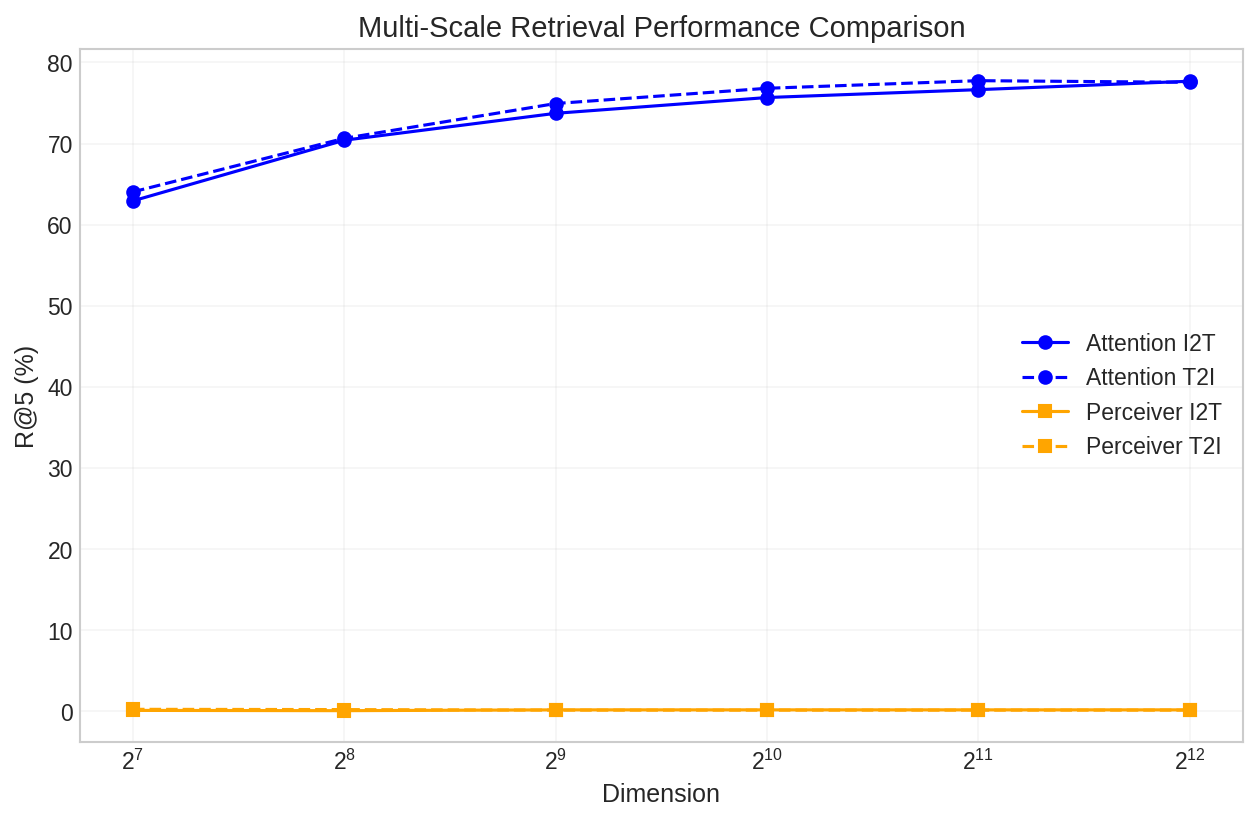

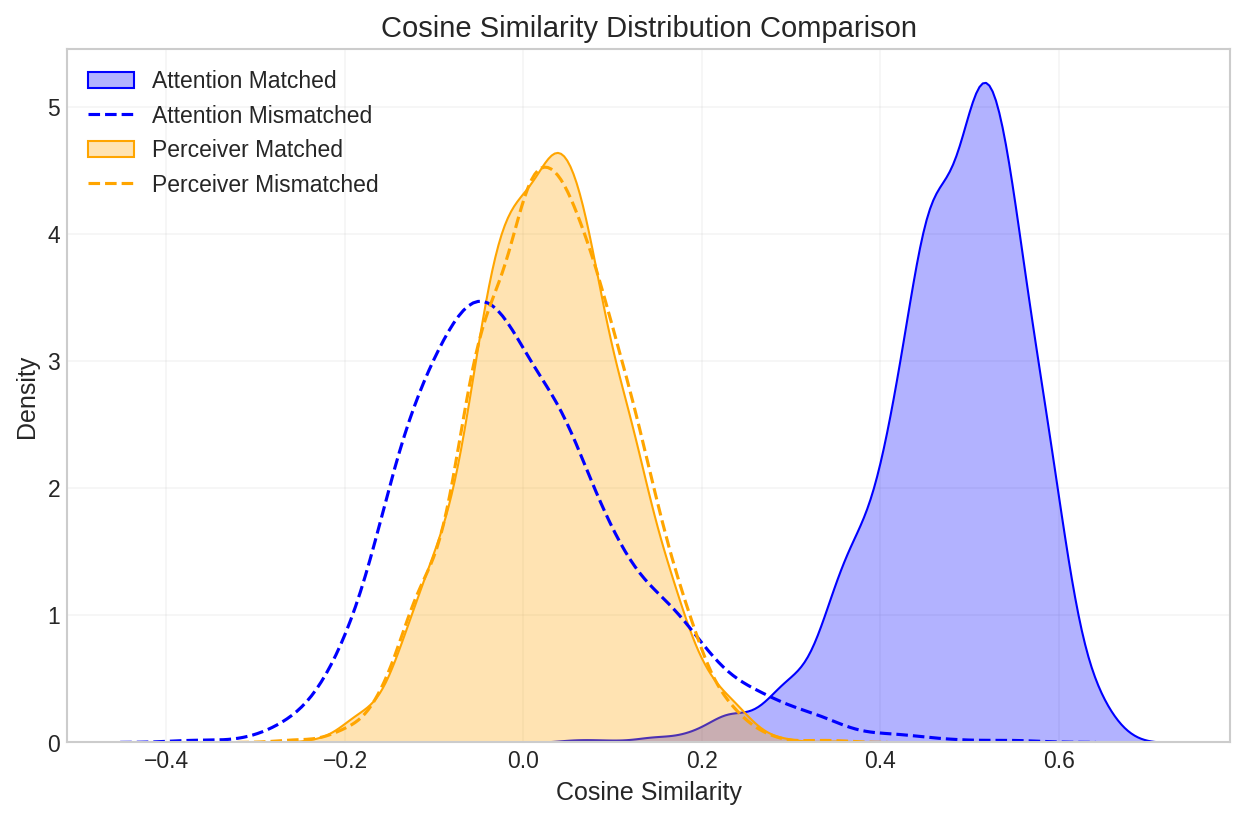

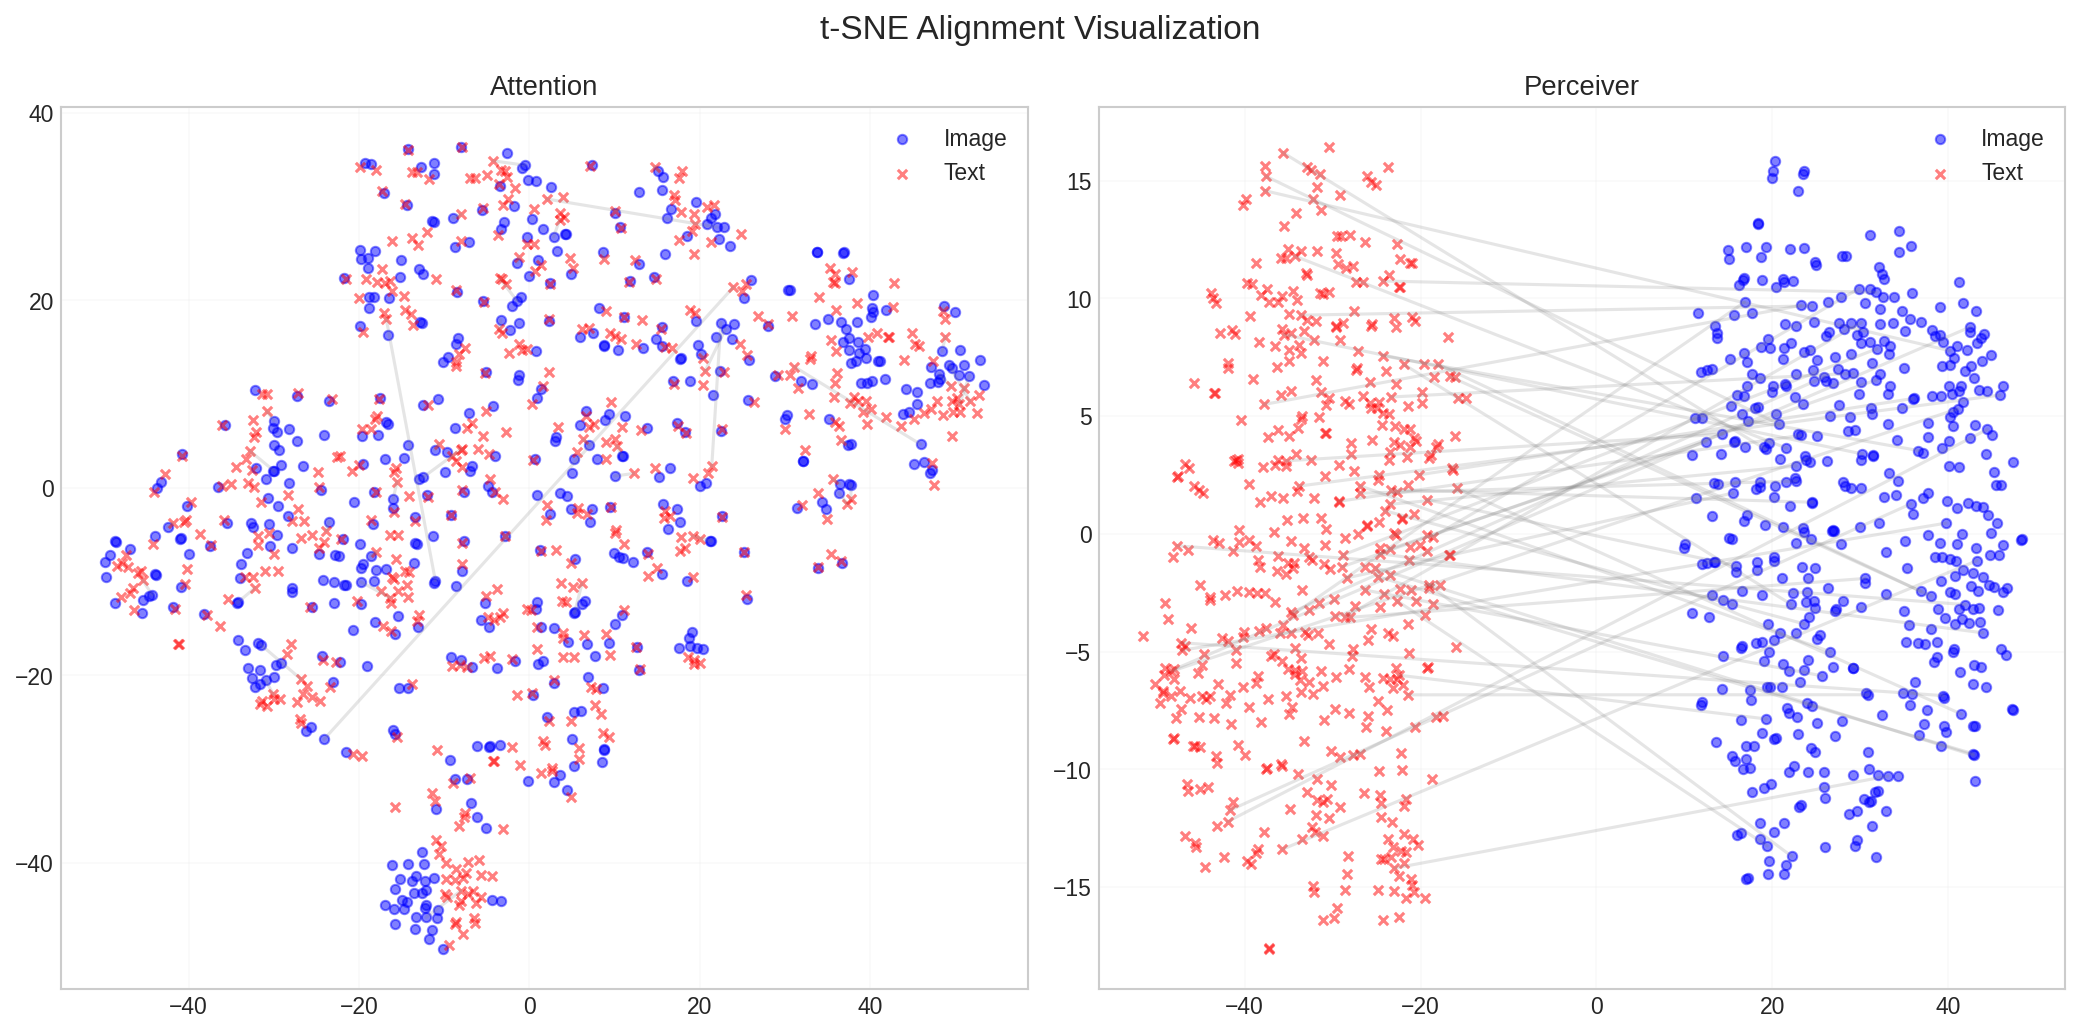

In [6]:
# 1. R@5 vs Dim (Combined Comparison)
plt.figure(figsize=(10, 6))
markers = {'attention': 'o', 'perceiver': 's'}
linestyles = {'i2t': '-', 't2i': '--'}
colors = {'attention': 'blue', 'perceiver': 'orange'}

for model in df_master['model'].unique():
    for direct in ['i2t', 't2i']:
        d = df_master[(df_master['model'] == model) & (df_master['direction'] == direct)].sort_values('dim')
        if not d.empty:
            plt.plot(d['dim'], d['R5'], 
                     marker=markers.get(model, 'x'), 
                     linestyle=linestyles.get(direct, ':'), 
                     color=colors.get(model, 'gray'),
                     label=f'{model.capitalize()} {direct.upper()}')

plt.xscale('log', base=2)
plt.xlabel('Dimension', fontsize=12)
plt.ylabel('R@5 (%)', fontsize=12)
plt.title('Multi-Scale Retrieval Performance Comparison', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.savefig(OUTPUT_DIR / 'plot_r5_dim_comparison_all.png')
plt.show()

# 2. Cosine Histograms (Combined)
plt.figure(figsize=(10, 6))
for model in embeddings:
    v = embeddings[model]['vision'][:2000].to(DEVICE)
    t = embeddings[model]['text'][:2000].to(DEVICE)
    
    # Matched
    sim_pos = (F.normalize(v) * F.normalize(t)).sum(-1).cpu().numpy()
    # Mismatched
    idx = torch.randperm(len(t))
    sim_neg = (F.normalize(v) * F.normalize(t[idx])).sum(-1).cpu().numpy()
    
    sns.kdeplot(sim_pos, fill=True, label=f'{model.capitalize()} Matched', color=colors.get(model, 'gray'), alpha=0.3)
    sns.kdeplot(sim_neg, fill=False, linestyle='--', label=f'{model.capitalize()} Mismatched', color=colors.get(model, 'gray'))

plt.title('Cosine Similarity Distribution Comparison', fontsize=14)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig(OUTPUT_DIR / 'plot_cosine_hist_comparison.png')
plt.show()

# 3. t-SNE (Side-by-Side)
try:
    from sklearn.manifold import TSNE
    
    model_names = list(embeddings.keys())
    if model_names:
        fig, axes = plt.subplots(1, len(model_names), figsize=(7*len(model_names), 7))
        if len(model_names) == 1: axes = [axes]
        
        for ax, model in zip(axes, model_names):
            v = embeddings[model]['vision'][:500].cpu().numpy()
            t = embeddings[model]['text'][:500].cpu().numpy()
            combined = np.concatenate([v, t])
            
            perp = min(30, len(combined)-1)
            tsne = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(combined)
            
            ax.scatter(tsne[:500,0], tsne[:500,1], c='blue', alpha=0.5, label='Image', s=20)
            ax.scatter(tsne[500:,0], tsne[500:,1], c='red', marker='x', alpha=0.5, label='Text', s=20)
            
            for i in range(50):
                ax.plot([tsne[i,0], tsne[500+i,0]], [tsne[i,1], tsne[500+i,1]], 'gray', alpha=0.2)
                
            ax.set_title(f'{model.capitalize()}')
            ax.legend()
            ax.grid(True, alpha=0.1)
            
        plt.suptitle('t-SNE Alignment Visualization', fontsize=16)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'plot_tsne_comparison.png')
        plt.show()
except ImportError:
    print("sklearn needed for t-SNE.")
except Exception as e:
    print(f"t-SNE Error: {e}")


## 7. Reports & Summary

In [7]:
print("="*50)
print("FINAL EVALUATION REPORT SUMMARY")
print("="*50)
print(f"Models Evaluated: {list(embeddings.keys())}")
print(f"Dimensions: {config.mrl_dims}")
print(f"Split: {config.split}")
print(f"Output Directory: {OUTPUT_DIR}")
print("\nGenerated Artifacts:")
for f in os.listdir(OUTPUT_DIR):
    print(f" - {f}")

FINAL EVALUATION REPORT SUMMARY
Models Evaluated: ['attention', 'perceiver']
Dimensions: [4096, 2048, 1024, 512, 256, 128]
Split: val
Output Directory: /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/outputs/alignment_eval_final

Generated Artifacts:
 - alignment_metrics_all_models.csv
 - embeddings_val_perceiver.pt
 - table_multiscale_combined.csv
 - table_cross_model_comparison.csv
 - plot_r5_dim_comparison_all.png
 - plot_cosine_hist_comparison.png
 - table_cross_model_comparison.tex
 - table_multiscale_combined.tex
 - plot_tsne_comparison.png
 - embeddings_val_attention.pt
 - table_4096_detailed.csv


## 8. External Benchmark Evaluation (CIFAR-10 & COCO)

This section runs an external script to evaluate the trained models on CIFAR-10 (Zero-Shot) and COCO (Retrieval).
The script loads the checkpoints, downloads/loads the datasets, and performs standard evaluation.
Note: Outputs are printed to stdout.


In [8]:
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F

# Ensure models are loaded
if 'models' not in locals():
    print("Models dictionary not available. Please run the model loading cells first.")
else:
    print(f"\nEvaluating on External Benchmarks. Device: {DEVICE}")

    # --- CIFAR-10 Evaluation ---
    print("\n" + "=" * 40)
    print(" CIFAR-10 Zero-Shot Classification")
    print("=" * 40)

    transform = T.Compose([
        T.Resize((336, 336), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

    data_dir = ROOT_DIR / 'data'
    try:
        cifar_ds = torchvision.datasets.CIFAR10(root=str(data_dir), train=False, download=True, transform=transform)
        cifar_loader = DataLoader(cifar_ds, batch_size=32, shuffle=False, num_workers=4)
        print(f"Loaded CIFAR-10 Test Set: {len(cifar_ds)} images.")
    except Exception as e:
        print(f"Failed to load CIFAR-10: {e}")
        cifar_loader = None

    if cifar_loader:
        classes = cifar_ds.classes
        prompts = [f"a photo of a {c}" for c in classes]
        print(f"Classes: {classes}")

        prompt_embeds = {}

        # Ensure tokenizer is available
        if 'txt_tok' not in locals():
            txt_tok = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

        with torch.no_grad():
            toks = txt_tok(prompts, padding=True, truncation=True, return_tensors='pt').to(DEVICE)

            # 1. Attention Model Text Features
            if 'attention' in models:
                try:
                    out = models['attention'](texts=prompts, return_embeddings=True)
                    emb = out.text_emb
                    prompt_embeds['attention'] = F.normalize(emb, p=2, dim=-1)
                except Exception as e:
                    print(f"Attention Text Encode Error: {e}")

            # 2. Perceiver Model Text Features
            if 'perceiver' in models:
                try:
                    hf_out = models['perceiver'].t(**toks)
                    txt_feats = hf_out.last_hidden_state
                    emb = models['perceiver'].p.encode_text(txt_feats)
                    prompt_embeds['perceiver'] = F.normalize(emb, p=2, dim=-1)
                except Exception as e:
                    print(f"Perceiver Text Encode Error: {e}")

        correct = {k: 0 for k in prompt_embeds}
        total = 0

        clip_vis = models['perceiver'].c if 'perceiver' in models else None

        for imgs, labels in tqdm(cifar_loader, desc="Evaluating CIFAR-10"):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            total += imgs.shape[0]

            with torch.no_grad():
                vis_feats = None
                if 'perceiver' in prompt_embeds and clip_vis is not None:
                    clip_out = clip_vis(pixel_values=imgs)
                    vis_feats = clip_out.last_hidden_state

                for name, model in models.items():
                    if name not in prompt_embeds:
                        continue

                    if name == 'attention':
                        out = model(images=imgs, return_embeddings=True)
                        v_emb = out.vision_emb
                    elif name == 'perceiver':
                        if vis_feats is None:
                            continue
                        v_emb = model.p.encode_vision(vis_feats)
                    else:
                        continue  # skip any other models

                    v_emb = F.normalize(v_emb, p=2, dim=-1)

                    sims = v_emb @ prompt_embeds[name].t()
                    preds = sims.argmax(dim=1)
                    correct[name] += (preds == labels).sum().item()

        if total > 0:
            print("\nResults (Accuracy %):")
            for name, corr in correct.items():
                acc = 100 * corr / total
                print(f"{name.capitalize()}: {acc:.2f}%")
        else:
            print("No samples processed.")

    # --- COCO Evaluation (Stub) ---
    print("\n" + "=" * 40)
    print(" COCO Retrieval Evaluation")
    print("=" * 40)

    coco_path = data_dir / 'coco'
    if not coco_path.exists() and not (data_dir / 'annotations').exists():
        print("COCO Dataset not found in 'data/' directory. Skipping.")
    else:
        print("COCO Dataset found (placeholder logic).")



Evaluating on External Benchmarks. Device: cuda

 CIFAR-10 Zero-Shot Classification
Loaded CIFAR-10 Test Set: 10000 images.
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Evaluating CIFAR-10:   0%|          | 0/313 [00:00<?, ?it/s]


Results (Accuracy %):
Attention: 88.69%
Perceiver: 10.30%

 COCO Retrieval Evaluation
COCO Dataset not found in 'data/' directory. Skipping.
